# Continuous-Time Diffusion Modeling Demo

In this notebook, we implement and document a continuous-time diffusion model based on the EDM model proposed in [0] by Karras et al. As a proof-of-concept, we apply the model to generating (conditioned) samples from the MNIST digit dataset. The code is in many places almost verbatim from the code [1] by Karras et al., which is copyrighted by the NVIDIA CORPORATION & AFFILIATES and published under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International licence.

[0] T. Karras, M. Aittala, T. Aila, S. Laine. Elucidating the design space of diffusion-based generative models. NeurIPS 2022 (2022), <https://arxiv.org/abs/2206.00364>  
[1] https://github.com/NVlabs/edm

Please see the comments in the imported code for more details on how the machine learning models are set up and trained.


## Imports, Setup, and Training Data

In [1]:
# External libraries
import numpy as np

import torch
import torchvision.datasets as datasets
from torchvision.transforms.v2 import Compose, Lambda, ToDtype
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [2]:
# Own libraries.
from networks import DhariwalUNet, EDMPrecond
from losses import EDMLoss
from samplers import edm_sampler

In [3]:
# Set up torch-related variables.
device = "cuda"
eps = 1e-5

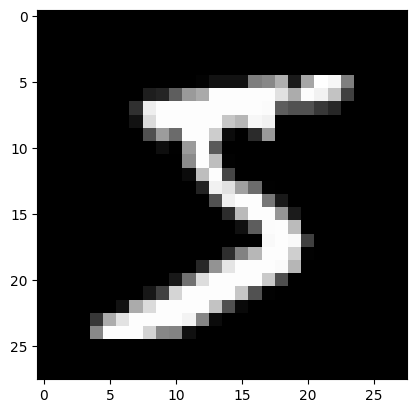

In [4]:
# Load the training data.
batch_size = 64 # Batch size for training data sampling.
label_dim = 10  # The number of labels for the training data samples.

class CustomDataset(Dataset):
    """Custom dataset to add the channel information to an image dataset and to
    get labels as one-hot encoded vectors."""

    def __init__(self, dataset, label_dim=0, transform=None):
        self.data = dataset.data
        self.labels = dataset.targets
        self.label_dim = label_dim
        self.transform = transform if transform is not None else lambda x: x
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.numpy()
        if isinstance(idx, (list, np.ndarray)):
            images = self.data[idx]
            labels = self.labels[idx]
            return self.transform(images).unsqueeze(1), torch.nn.functional.one_hot(labels, self.label_dim)
        else:
            return self.transform(self.data[idx]).unsqueeze(0), torch.nn.functional.one_hot(self.labels[idx], self.label_dim)

mnist_trainset = CustomDataset(datasets.MNIST(root="./data", train=True, download=False), label_dim=10, transform=Compose([ToDtype(torch.float32, scale=True), Lambda(lambda x: (x-0.5)*2)]))
training_data = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)

img_channels = mnist_trainset[0][0].shape[0]
img_resolution = mnist_trainset[0][0].shape[1]

# Show an image from the dataset.
plt.imshow(mnist_trainset[0][0].squeeze(), cmap="grey")

## Training

In [5]:
def train_denoise_model(model, dataset, epochs=1, seed=0):
    """Train the denoising model to be used in computing the score function. The argument
    epochs controls how many times the whole training data is considered. This
    number can be fractional, e.g., epochs=1.5 means that 1.5 times the total
    number of batches in the whole training data are considered."""
    
    device = next(model.parameters()).device

    # Random seed.
    # TODO: Is this the proper place to set the seed?
    torch.manual_seed(seed)
    
    batches_in_data = len(dataset)
    n_batches = int(epochs*batches_in_data) # How many batches to get from the training data to train on.
    
    # Loss. We use the loss proposed in [0].
    loss_fn = EDMLoss()
    
    # Set up optimizer.
    lr = 0.0001
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    seen_batches = 0
    done = False
    adjust_lr = False
    dataset_iterator = iter(dataset)
    while not done:
        try:
            images, labels = next(dataset_iterator)
        except StopIteration:
            dataset_iterator = iter(dataset)
            continue
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        loss = loss_fn(model=model, images=images, labels=labels)
        loss.backward()
        optimizer.step()
        print(loss.item())

        seen_batches += 1
        
        # Adjust learning rate. Does not seem to matter much in this demo, but
        # fun to try out.
        if seen_batches == 300:
            new_lr = 0.0001
            adjust_lr = True
        elif seen_batches == 600:
            new_lr = 0.00001
            adjust_lr = True
        
        if adjust_lr:
            print(f"Adjusting learning rate to {new_lr}.")
            for g in optimizer.param_groups:
                g["lr"] = new_lr
            adjust_lr = False
        
        done = seen_batches >= n_batches

## Model Creation and Its Training

In [6]:
# Nonpreconditioned denoising model.
unet = DhariwalUNet(
    img_resolution=img_resolution,
    in_channels=img_channels,
    out_channels=img_channels,
    label_dim=label_dim,
    channel_mult=[1,2,3]           # We can divide 28 (img_resolution) only twice to an even number.
).to(device)
# Conditioned denoising model.
denoise_model = EDMPrecond(model=unet).to(device)

In [7]:
# Train the model.
seed = 0
train_denoise_model(model=denoise_model, dataset=training_data, seed=seed)

1519.040283203125
1374.1041259765625
1403.5042724609375
1329.1890869140625
1249.66064453125
1121.655517578125
1254.98291015625
1021.0628662109375
1006.5692138671875
972.5458984375
894.2977294921875
879.14111328125
895.58837890625
914.3251953125
901.9954223632812
883.2091064453125
931.4009399414062
924.8812255859375
826.8961181640625
875.1609497070312
894.9146728515625
841.462646484375
810.8568115234375
793.67333984375
750.1527099609375
749.5794677734375
784.5185546875
779.7130737304688
708.7446899414062
730.1119995117188
722.3758544921875
678.0880126953125
683.1883544921875
685.6619873046875
657.6014404296875
630.9125366210938
685.552001953125
629.9373779296875
640.0760498046875
592.80224609375
633.7268676757812
593.5442504882812
609.70068359375
575.5648193359375
573.06982421875
606.0321655273438
598.2952880859375
552.9144897460938
590.8798828125
567.260986328125
551.672119140625
546.7593994140625
535.2775268554688
546.5061645507812
542.0401000976562
568.39404296875
628.914794921875
55

## Check Denoising Performance

In [8]:
def test_denoise_image(model, images, labels=None):
    """Add noise to the given images and denoise them with the given model.
    Both noised images and denoised are returned."""
    
    device = next(model.parameters()).device
    images = images.to(device)
    labels = labels.to(device) if labels is not None else labels

    # Sample random noise scales sigma.
    loss = EDMLoss()
    P_mean = loss.P_mean
    P_std = loss.P_std
    rnd_normal = torch.randn([images.shape[0], 1, 1, 1], device=images.device)
    sigma = (rnd_normal*P_std + P_mean).exp()

    # Add the noise n and denoise the resulting images y + n.
    y = images
    n = torch.randn_like(y)*sigma
    z = y + n
    denoised = model(z, sigma, labels)

    return z, denoised

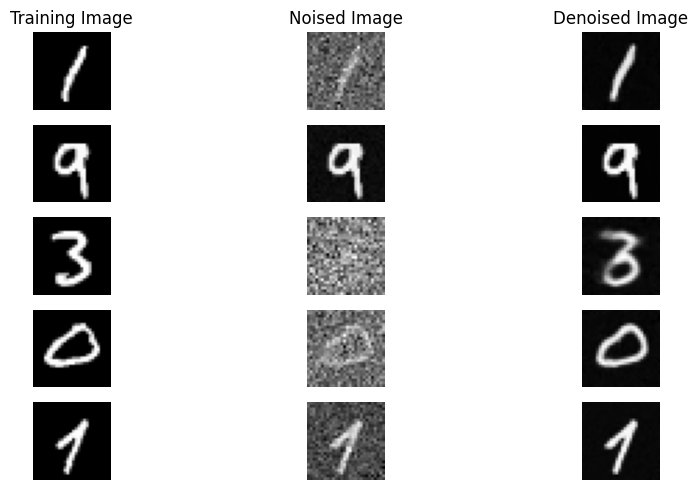

In [12]:
# Pick some random images from the training data and check visually how well
# the denoising model performs on them.
n = 5
idx = torch.randint(len(mnist_trainset), size=(n, ))
images = mnist_trainset[idx][0]
labels = mnist_trainset[idx][1]

noised, denoised = test_denoise_image(denoise_model, images, labels=labels)
noised = noised.detach().cpu()
denoised = denoised.detach().cpu()

fig, ax = plt.subplots(n, 3, figsize=(10, 5))
for a, title in zip(ax[0], ["Training Image", "Noised Image", "Denoised Image"]):
    a.set_title(title)
for i in range(n):
    ax[i,0].set_axis_off()
    ax[i,0].imshow(images[i].squeeze(0, 1), cmap="grey")
    ax[i,1].set_axis_off()
    ax[i,1].imshow(noised[i].squeeze(0, 1), cmap="grey")
    ax[i,2].set_axis_off()
    ax[i,2].imshow(denoised[i].squeeze(0, 1), cmap="grey")
fig.tight_layout()
plt.show()

## Sample Fresh Samples from Noise

Class labels: [1, 9, 8, 2, 1]


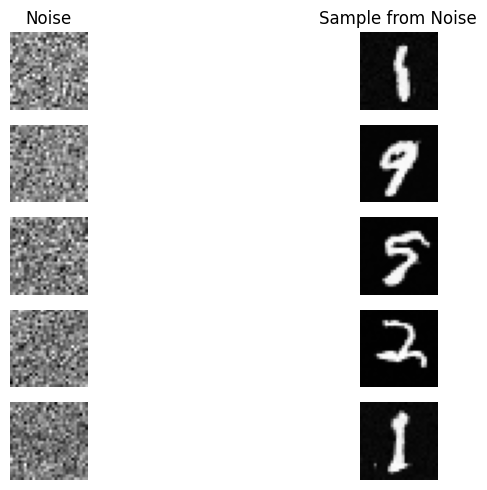

In [24]:
samples = 5      # How many samples to generate.
class_idx = None # Class from which to sample from. None means random class.
net = denoise_model

# Create noise (i.e., latents) from which samples are generated.
latents = torch.randn([samples, img_channels, img_resolution, img_resolution], device=device)

# Create class labels.
class_labels = None
if net.label_dim:
    class_labels = torch.eye(net.label_dim, device=device)[torch.randint(net.label_dim, size=[samples], device=device)]
if class_idx is not None:
    class_labels[:,:] = 0
    class_labels[:,class_idx] = 1

# Generate images.
sampler_fn = edm_sampler
images = sampler_fn(net, latents, class_labels)

latents = latents.detach().cpu()
images = images.detach().cpu()

print(f"Class labels: {torch.argmax(class_labels, dim=1).tolist()}")

fig, ax = plt.subplots(samples, 2, figsize=(10, 5))
for a, title in zip(ax[0], ["Noise", "Sample from Noise"]):
    a.set_title(title)
for i in range(samples):
    ax[i,0].set_axis_off()
    ax[i,0].imshow(latents[i].squeeze(0, 1), cmap="grey")
    ax[i,1].set_axis_off()
    ax[i,1].imshow(images[i].squeeze(0, 1), cmap="grey")
fig.tight_layout()
plt.show()